In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import time
import copy
import os
import random

In [2]:
import torch
model = torch.hub.load('pytorch/vision:v0.9.0', 'squeezenet1_1', pretrained=False)
model.eval()

Using cache found in C:\Users\Otakuking/.cache\torch\hub\pytorch_vision_v0.9.0


SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): MaxPool2d

In [3]:
batch_size = 64
learning_rate = 0.001
random_seed = 555
random.seed(random_seed)
torch.manual_seed(random_seed)

transforms = transforms.Compose([
    transforms.Resize(48),
    transforms.CenterCrop(48),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4927, 0.4927, 0.4927], std=[0.4999, 0.4999, 0.4999]),
])
train_dataset = datasets.ImageFolder(root='emotion4ver/train/', transform=transforms)
test_dataset = datasets.ImageFolder(root='emotion4ver/test/', transform=transforms)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
def imshow(inp, title=None):
    
    inp = inp.cpu() if device else inp
    inp = inp.numpy().transpose((1, 2, 0))
    
    mean = np.array([0.4927, 0.4927, 0.4927])
    std = np.array([0.4999, 0.4999, 0.4999])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

images-size: torch.Size([64, 3, 48, 48])
out-size: torch.Size([3, 402, 402])


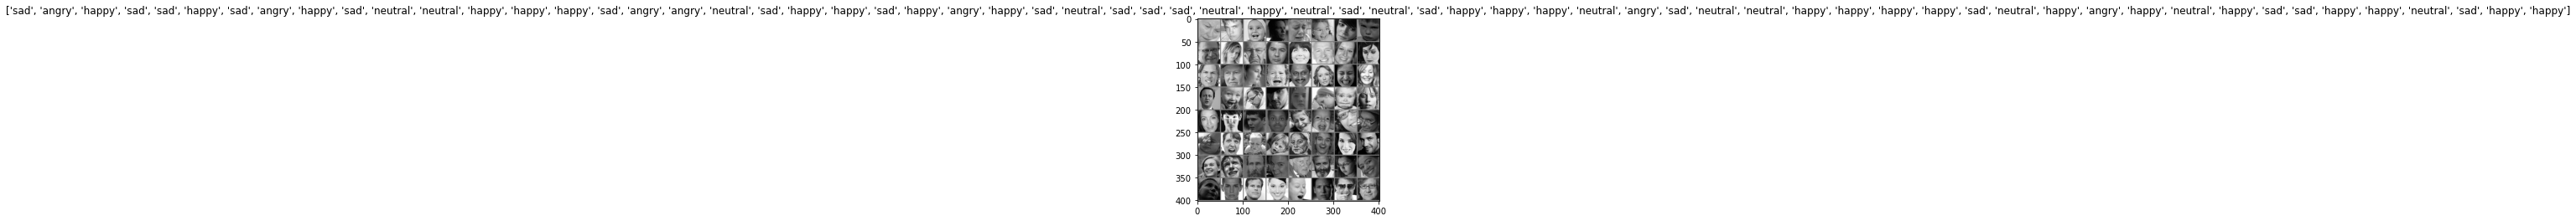

In [5]:
images, labels = next(iter(train_dataloader)) 
print("images-size:", images.shape)

out = torchvision.utils.make_grid(images)
print("out-size:", out.shape)

imshow(out, title=[train_dataset.classes[x] for x in labels])

In [6]:
net = model
net = net.cuda() if device else net
net

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): MaxPool2d

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001, 
                 betas=(0.9, 0.999), 
                 eps=1e-08, 
                 weight_decay=0, 
                 amsgrad=False)

def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

In [8]:
n_epochs = 100
print_every = 10
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_dataloader)
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_dataloader):
        data_, target_ = data_.to(device), target_.to(device)
        optimizer.zero_grad()
        
        outputs = net(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        net.eval()
        for data_t, target_t in (test_dataloader):
            data_t, target_t = data_t.to(device), target_t.to(device)
            outputs_t = net(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t/total_t)
        val_loss.append(batch_loss/len(test_dataloader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')

        
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(net.state_dict(), 'Squeezenet1.1_lr0.001_batch64_epoch50_imsize48_CalcMeanStd_emotion6ver.pt')
            print('Improvement-Detected, save-model')
    net.train()

Epoch 1

Epoch [1/100], Step [0/234], Loss: 6.9354
Epoch [1/100], Step [20/234], Loss: 1.4506
Epoch [1/100], Step [40/234], Loss: 1.3916
Epoch [1/100], Step [60/234], Loss: 1.5326
Epoch [1/100], Step [80/234], Loss: 1.3632
Epoch [1/100], Step [100/234], Loss: 1.4658
Epoch [1/100], Step [120/234], Loss: 1.3969
Epoch [1/100], Step [140/234], Loss: 1.3895
Epoch [1/100], Step [160/234], Loss: 1.4296
Epoch [1/100], Step [180/234], Loss: 1.3150
Epoch [1/100], Step [200/234], Loss: 1.6225
Epoch [1/100], Step [220/234], Loss: 1.2727

train-loss: 1.4926, train-acc: 31.7828
validation loss: 1.3003, validation acc: 38.9646

Improvement-Detected, save-model
Epoch 2

Epoch [2/100], Step [0/234], Loss: 1.4434
Epoch [2/100], Step [20/234], Loss: 1.2841
Epoch [2/100], Step [40/234], Loss: 1.2464
Epoch [2/100], Step [60/234], Loss: 1.2910
Epoch [2/100], Step [80/234], Loss: 1.4482
Epoch [2/100], Step [100/234], Loss: 1.2990
Epoch [2/100], Step [120/234], Loss: 1.3255
Epoch [2/100], Step [140/234], Loss

Epoch [13/100], Step [180/234], Loss: 0.9344
Epoch [13/100], Step [200/234], Loss: 0.8421
Epoch [13/100], Step [220/234], Loss: 0.8197

train-loss: 1.0644, train-acc: 62.4129
validation loss: 1.0546, validation acc: 58.4297

Epoch 14

Epoch [14/100], Step [0/234], Loss: 0.9424
Epoch [14/100], Step [20/234], Loss: 0.8022
Epoch [14/100], Step [40/234], Loss: 1.0116
Epoch [14/100], Step [60/234], Loss: 0.7108
Epoch [14/100], Step [80/234], Loss: 0.8469
Epoch [14/100], Step [100/234], Loss: 0.7922
Epoch [14/100], Step [120/234], Loss: 0.8730
Epoch [14/100], Step [140/234], Loss: 0.6575
Epoch [14/100], Step [160/234], Loss: 0.8681
Epoch [14/100], Step [180/234], Loss: 0.7852
Epoch [14/100], Step [200/234], Loss: 1.0033
Epoch [14/100], Step [220/234], Loss: 0.9450

train-loss: 1.0491, train-acc: 63.5054
validation loss: 1.0499, validation acc: 57.4633

Epoch 15

Epoch [15/100], Step [0/234], Loss: 0.8895
Epoch [15/100], Step [20/234], Loss: 0.8038
Epoch [15/100], Step [40/234], Loss: 0.7883


Epoch [26/100], Step [160/234], Loss: 0.6209
Epoch [26/100], Step [180/234], Loss: 0.9181
Epoch [26/100], Step [200/234], Loss: 0.4822
Epoch [26/100], Step [220/234], Loss: 0.7032

train-loss: 0.8954, train-acc: 75.7976
validation loss: 1.0482, validation acc: 59.9827

Epoch 27

Epoch [27/100], Step [0/234], Loss: 0.6700
Epoch [27/100], Step [20/234], Loss: 0.6223
Epoch [27/100], Step [40/234], Loss: 0.4532
Epoch [27/100], Step [60/234], Loss: 0.5401
Epoch [27/100], Step [80/234], Loss: 0.4953
Epoch [27/100], Step [100/234], Loss: 0.3411
Epoch [27/100], Step [120/234], Loss: 0.5730
Epoch [27/100], Step [140/234], Loss: 0.6191
Epoch [27/100], Step [160/234], Loss: 0.8366
Epoch [27/100], Step [180/234], Loss: 0.7677
Epoch [27/100], Step [200/234], Loss: 0.5022
Epoch [27/100], Step [220/234], Loss: 0.4776

train-loss: 0.8831, train-acc: 77.3123
validation loss: 1.0527, validation acc: 60.0518

Epoch 28

Epoch [28/100], Step [0/234], Loss: 0.4519
Epoch [28/100], Step [20/234], Loss: 0.5380

Epoch [39/100], Step [140/234], Loss: 0.3918
Epoch [39/100], Step [160/234], Loss: 0.3152
Epoch [39/100], Step [180/234], Loss: 0.2147
Epoch [39/100], Step [200/234], Loss: 0.5193
Epoch [39/100], Step [220/234], Loss: 0.3676

train-loss: 0.7441, train-acc: 87.7882
validation loss: 1.1570, validation acc: 61.1389

Epoch 40

Epoch [40/100], Step [0/234], Loss: 0.2019
Epoch [40/100], Step [20/234], Loss: 0.2087
Epoch [40/100], Step [40/234], Loss: 0.2895
Epoch [40/100], Step [60/234], Loss: 0.3612
Epoch [40/100], Step [80/234], Loss: 0.1418
Epoch [40/100], Step [100/234], Loss: 0.2063
Epoch [40/100], Step [120/234], Loss: 0.2428
Epoch [40/100], Step [140/234], Loss: 0.3199
Epoch [40/100], Step [160/234], Loss: 0.1520
Epoch [40/100], Step [180/234], Loss: 0.2595
Epoch [40/100], Step [200/234], Loss: 0.3125
Epoch [40/100], Step [220/234], Loss: 0.1021

train-loss: 0.7331, train-acc: 88.9008
validation loss: 1.1682, validation acc: 59.6031

Epoch 41

Epoch [41/100], Step [0/234], Loss: 0.147

Epoch [52/100], Step [120/234], Loss: 0.2492
Epoch [52/100], Step [140/234], Loss: 0.1109
Epoch [52/100], Step [160/234], Loss: 0.1075
Epoch [52/100], Step [180/234], Loss: 0.3250
Epoch [52/100], Step [200/234], Loss: 0.1744
Epoch [52/100], Step [220/234], Loss: 0.2118

train-loss: 0.6191, train-acc: 93.3110
validation loss: 1.3000, validation acc: 58.3952

Epoch 53

Epoch [53/100], Step [0/234], Loss: 0.1633
Epoch [53/100], Step [20/234], Loss: 0.3712
Epoch [53/100], Step [40/234], Loss: 0.2195
Epoch [53/100], Step [60/234], Loss: 0.4493
Epoch [53/100], Step [80/234], Loss: 0.2080
Epoch [53/100], Step [100/234], Loss: 0.1582
Epoch [53/100], Step [120/234], Loss: 0.1322
Epoch [53/100], Step [140/234], Loss: 0.1652
Epoch [53/100], Step [160/234], Loss: 0.2893
Epoch [53/100], Step [180/234], Loss: 0.1213
Epoch [53/100], Step [200/234], Loss: 0.1276
Epoch [53/100], Step [220/234], Loss: 0.2234

train-loss: 0.6117, train-acc: 91.8633
validation loss: 1.3081, validation acc: 58.2399

Epoch 

Epoch [65/100], Step [100/234], Loss: 0.0458
Epoch [65/100], Step [120/234], Loss: 0.4187
Epoch [65/100], Step [140/234], Loss: 0.0908
Epoch [65/100], Step [160/234], Loss: 0.2162
Epoch [65/100], Step [180/234], Loss: 0.0311
Epoch [65/100], Step [200/234], Loss: 0.0820
Epoch [65/100], Step [220/234], Loss: 0.0317

train-loss: 0.5278, train-acc: 94.9799
validation loss: 1.4470, validation acc: 59.1544

Epoch 66

Epoch [66/100], Step [0/234], Loss: 0.1544
Epoch [66/100], Step [20/234], Loss: 0.1537
Epoch [66/100], Step [40/234], Loss: 0.1444
Epoch [66/100], Step [60/234], Loss: 0.1978
Epoch [66/100], Step [80/234], Loss: 0.2415
Epoch [66/100], Step [100/234], Loss: 0.1742
Epoch [66/100], Step [120/234], Loss: 0.0560
Epoch [66/100], Step [140/234], Loss: 0.0491
Epoch [66/100], Step [160/234], Loss: 0.0497
Epoch [66/100], Step [180/234], Loss: 0.0577
Epoch [66/100], Step [200/234], Loss: 0.1934
Epoch [66/100], Step [220/234], Loss: 0.4059

train-loss: 0.5220, train-acc: 95.2547
validation 

Epoch [78/100], Step [80/234], Loss: 0.2577
Epoch [78/100], Step [100/234], Loss: 0.0964
Epoch [78/100], Step [120/234], Loss: 0.3844
Epoch [78/100], Step [140/234], Loss: 0.1640
Epoch [78/100], Step [160/234], Loss: 0.0581
Epoch [78/100], Step [180/234], Loss: 0.0498
Epoch [78/100], Step [200/234], Loss: 0.0892
Epoch [78/100], Step [220/234], Loss: 0.1072

train-loss: 0.4624, train-acc: 96.6689
validation loss: 1.5612, validation acc: 59.1717

Epoch 79

Epoch [79/100], Step [0/234], Loss: 0.1521
Epoch [79/100], Step [20/234], Loss: 0.1667
Epoch [79/100], Step [40/234], Loss: 0.1077
Epoch [79/100], Step [60/234], Loss: 0.1180
Epoch [79/100], Step [80/234], Loss: 0.1519
Epoch [79/100], Step [100/234], Loss: 0.1482
Epoch [79/100], Step [120/234], Loss: 0.0664
Epoch [79/100], Step [140/234], Loss: 0.0767
Epoch [79/100], Step [160/234], Loss: 0.0783
Epoch [79/100], Step [180/234], Loss: 0.1868
Epoch [79/100], Step [200/234], Loss: 0.0533
Epoch [79/100], Step [220/234], Loss: 0.1455

train-

Epoch [91/100], Step [60/234], Loss: 0.0295
Epoch [91/100], Step [80/234], Loss: 0.0529
Epoch [91/100], Step [100/234], Loss: 0.0278
Epoch [91/100], Step [120/234], Loss: 0.1159
Epoch [91/100], Step [140/234], Loss: 0.2673
Epoch [91/100], Step [160/234], Loss: 0.0969
Epoch [91/100], Step [180/234], Loss: 0.1835
Epoch [91/100], Step [200/234], Loss: 0.0599
Epoch [91/100], Step [220/234], Loss: 0.0667

train-loss: 0.4124, train-acc: 96.7426
validation loss: 1.6557, validation acc: 60.1553

Epoch 92

Epoch [92/100], Step [0/234], Loss: 0.0688
Epoch [92/100], Step [20/234], Loss: 0.1141
Epoch [92/100], Step [40/234], Loss: 0.0305
Epoch [92/100], Step [60/234], Loss: 0.0492
Epoch [92/100], Step [80/234], Loss: 0.1084
Epoch [92/100], Step [100/234], Loss: 0.1501
Epoch [92/100], Step [120/234], Loss: 0.2209
Epoch [92/100], Step [140/234], Loss: 0.0650
Epoch [92/100], Step [160/234], Loss: 0.0659
Epoch [92/100], Step [180/234], Loss: 0.0749
Epoch [92/100], Step [200/234], Loss: 0.0549
Epoch [9

In [9]:
for i in range(len(train_acc)):
    train_acc[i] = train_acc[i] / 100
for i in range(len(val_acc)):
    val_acc[i] = val_acc[i] / 100

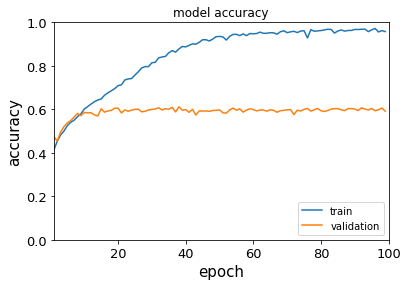

In [11]:
fig = plt.title("model accuracy")
plt.plot(train_acc)
plt.plot(val_acc)
plt.axis([1, 100, 0, 1])
plt.ylabel("accuracy", fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel("epoch", fontsize=15)
plt.legend(["train", "validation"], loc="lower right")
plt.show()